In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error



%matplotlib inline

## American Housing Survey Questionnaire - 2017

About: https://www.census.gov/programs-surveys/ahs.html

Download: http://www2.census.gov/programs-surveys/ahs/2017/AHS%202017%20National%20PUF%20v3.0%20Flat%20CSV.zip?#

Codebook: https://www.census.gov/data-tools/demo/codebook/ahs/ahsdict.html

Definitions: https://www2.census.gov/programs-surveys/ahs/2017/2017%20AHS%20Definitions.pdf?#


In [17]:
df = pd.read_csv("data/ahs2017n.csv")
print(df.shape)
df.head()

(66752, 3180)


,CONTROL,TOTROOMS,PERPOVLVL,COMTYPE,COMCOST,JACPRIMARY,JACSECNDRY,JADEQUACY,JBATHEXCLU,JBATHROOMS,...,JOBDIY28,JOBFUNDS26,JOBFUNDS27,JOBFUNDS28,JOBTYPE26,JOBTYPE27,JOBTYPE28,JOBWORKYR26,JOBWORKYR27,JOBWORKYR28
0,'11000001',8,501,'-6',-6,'0','0','2','0','0',...,'-9','-9','-9','-9','-9','-9','-9','-9','-9','-9'
1,'11000002',7,501,'-6',-6,'0','0','2','0','0',...,'-9','-9','-9','-9','-9','-9','-9','-9','-9','-9'
2,'11000005',8,501,'-6',-6,'0','0','2','0','0',...,'-9','-9','-9','-9','-9','-9','-9','-9','-9','-9'
3,'11000006',5,361,'-6',-6,'0','0','2','0','0',...,'-9','-9','-9','-9','-9','-9','-9','-9','-9','-9'
4,'11000007',8,501,'1',5564,'0','0','2','0','0',...,'-9','-9','-9','-9','-9','-9','-9','-9','-9','-9'


## Cleaning and Exploration

In [18]:
cols = [
    "YRBUILT",    # year built
    "LOTSIZE",    # size of lot
    "STORIES",    # number of stories
    "BEDROOMS",   # number of bedrooms
    "BATHROOMS",  # number of bathrooms
    "KITCHENS",   # number of kitches
    "NUMPEOPLE",  # number of people living in unit
    "TOTROOMS",   # total rooms
    "HHAGE",      # householder age
    "HINCP",      # household income
    "MARKETVAL",  # current market value
]

df_filtered = df[cols]
df_filtered = df_filtered[df_filtered['NUMPEOPLE'] > 0]
df_filtered = df_filtered[df_filtered['HINCP'] < 1_000_000]
df_filtered = df_filtered[df_filtered['MARKETVAL'] < 2_000_000]
df_filtered = df_filtered[df_filtered['MARKETVAL'] > 1_000]
df_filtered["BATHROOMS"] = df_filtered["BATHROOMS"].apply(lambda x: int(x.replace("'","")))
df_filtered["LOTSIZE"] = df_filtered["LOTSIZE"].apply(lambda x: int(x.replace("'","")))
df_filtered = df_filtered[df_filtered['LOTSIZE'] > 0]


df_filtered.shape

(31001, 11)

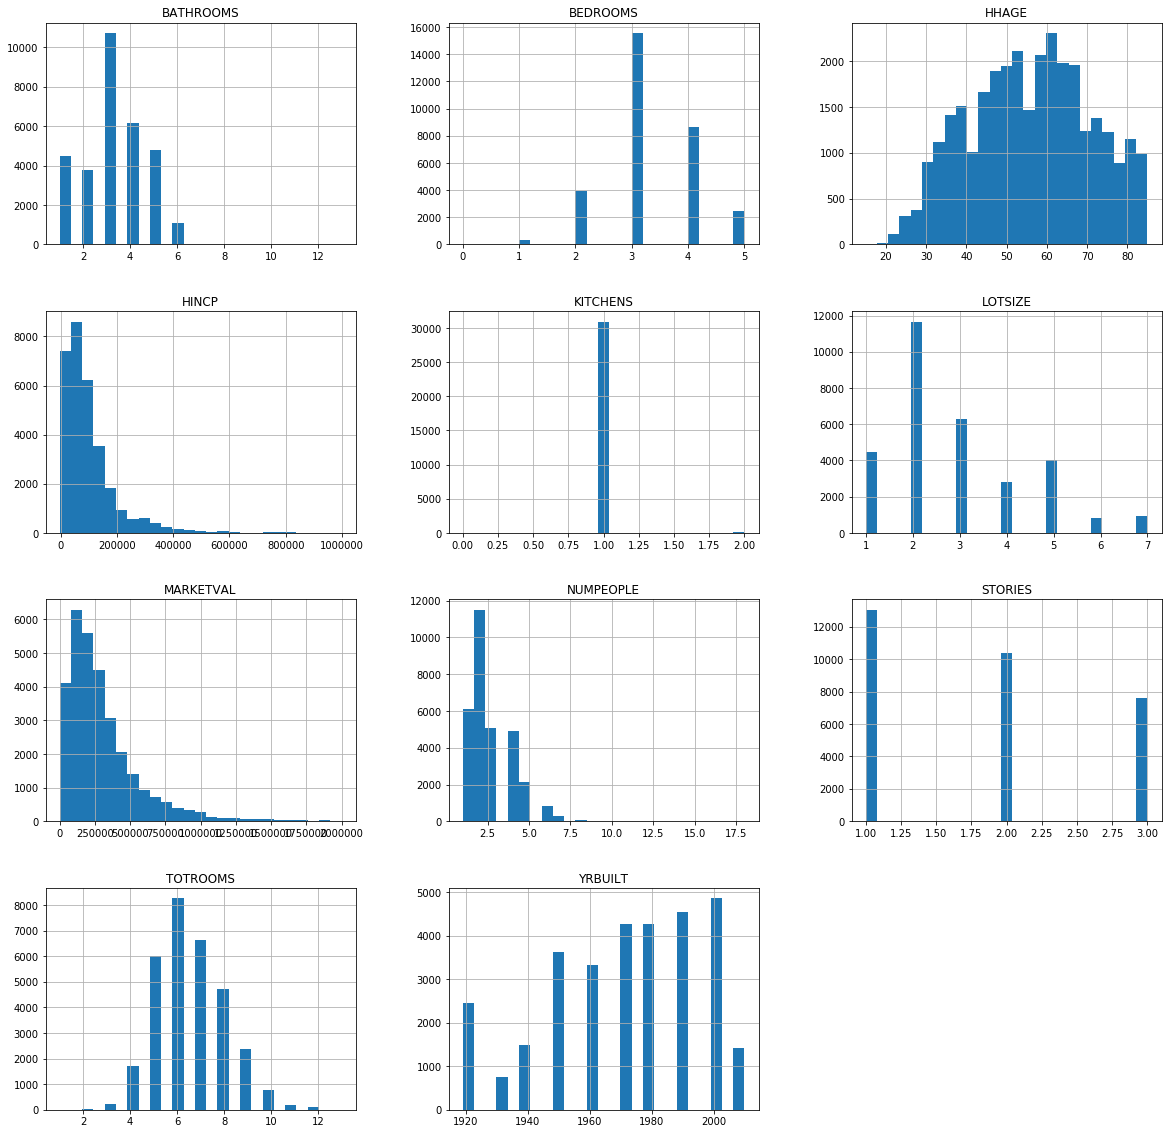

In [19]:
_ = df_filtered.hist(column=cols, bins=25, figsize=(20,20))

## K-Folds Cross Validation

In [20]:
df_filtered = df_filtered.sample(frac=1)
num_folds = 5
folds_counter = 0

def assign_k(row):
    global num_folds, folds_counter
    curr_num = folds_counter
    folds_counter = (folds_counter + 1) % num_folds
    return curr_num

df_filtered['k'] = df_filtered.apply(assign_k, axis=1)

df_train = df_filtered[df_filtered['k'] != 0]
df_test = df_filtered[df_filtered['k'] == 0]

## Model 1 - Multiple Linear Regression - Forward Stepwise Selection

In [21]:
predictors = cols[:-1]
selected_predictors = []
errors = []
smallest_error = float("inf")
smallest_error_index = 0

for j in range(len(predictors)):
    
    smallest_mse_index = 0
    smallest_mse = float("inf")
    
    for i, predictor in enumerate(predictors): 
        
        X = df_train[selected_predictors + [predictor]]
        X = sm.add_constant(X)
        Y = df_train["MARKETVAL"]
        model = sm.OLS(Y,X)
        results = model.fit()
        y_true = df_test["MARKETVAL"]
        y_pred = results.predict(sm.add_constant(df_test[selected_predictors + [predictor]]))
        mse = sm.tools.eval_measures.mse(y_true, y_pred)
        
        if mse < smallest_mse:
            smallest_mse = mse
            smallest_mse_index = i
            
            
    selected_predictors.append(predictors.pop(smallest_mse_index))
    errors.append(smallest_mse)
    
    if smallest_mse < smallest_error:
        smallest_error = smallest_mse
        smallest_error_index = j
        

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


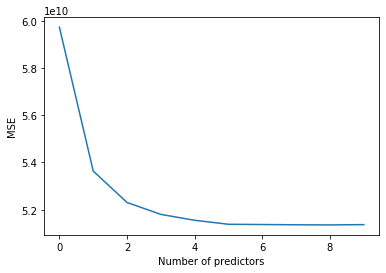

In [22]:
plt.plot(errors)
_ = plt.ylabel("MSE")
_ = plt.xlabel("Number of predictors")

In [23]:
# create best model
multiple_linear_regression_error = smallest_error
print("Top predictors: " + str(selected_predictors[:smallest_error_index+1]))
print("MSE: " + str(multiple_linear_regression_error))
X = df_train[selected_predictors[:smallest_error_index+1]]
X = sm.add_constant(X)
Y = df_train["MARKETVAL"]
model = sm.OLS(Y,X)
results = model.fit()
print(results.params)
results.summary()

Top predictors: ['BATHROOMS', 'HINCP', 'YRBUILT', 'TOTROOMS', 'HHAGE', 'LOTSIZE', 'BEDROOMS', 'KITCHENS', 'NUMPEOPLE']
MSE: 51355492438.3039
const        2.554618e+06
BATHROOMS    5.764642e+04
HINCP        8.479828e-01
YRBUILT     -1.319932e+03
TOTROOMS     2.563541e+04
HHAGE        1.405191e+03
LOTSIZE     -1.336289e+04
BEDROOMS    -4.073797e+03
KITCHENS    -1.023912e+05
NUMPEOPLE   -3.223514e+03
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              MARKETVAL   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     1168.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:11:40   Log-Likelihood:            -3.4107e+05
No. Observations:               24800   AIC:                         6.822e+05
Df Residuals:                   24790   BIC:                         6.822e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.555e+06   1.32e+05     19.328      0.000     2.3e+06    2.81e+06
BATHROOMS   5.765e+04   1515.491     38.038      0.000    5.47e+04    6.06e+04
HINCP          0.8480      0.016     53.287      0.000       0.817       0.879
YRBUILT    -1319.9318     65.231    -20.235      0.000   -1447.788   -1192.076
TOTROOMS    2.564e+04   1630.984     15.718      0.000    2.24e+04    2.88e+04
HHAGE       1405.1910    106.392     13.208      0.000    1196.657    1613.725
LOTSIZE    -1.336e+04    972.272    -13.744      0.000   -1.53e+04   -1.15e+04
BEDROOMS   -4073.7969   2892.968     -1.408      0.159   -9744.187    1596.594
KITCHENS   -1.024e+05    2.9e+04     -3.527      0.000   -1.59e+05   -4.55e+04
NUMPEOPLE  -3223.5137   1147.603     -2.809      0.005   -5472.884    -974.143
==============================================================================
Omnibus:                    11261.580   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77476.178
Skew:                           2.070   Prob(JB):                         0.00
Kurtosis:                      10.605   Cond. No.                     1.30e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 2 - Lasso Regression - Forward Stepwise Selection

In [24]:
predictors = cols[:-1]
selected_predictors = []
errors = []
smallest_error = float("inf")
smallest_error_index = 0

for j in range(len(predictors)):
    
    smallest_mse_index = 0
    smallest_mse = float("inf")
    
    for i, predictor in enumerate(predictors): 
        
        X = df_train[selected_predictors + [predictor]]
        Y = df_train["MARKETVAL"]
        lasso = Lasso()
        lasso.fit(X, Y)
        y_true = df_test["MARKETVAL"]
        y_pred = lasso.predict(df_test[selected_predictors + [predictor]])        
        mse = mean_squared_error(y_true, y_pred)
        
        if mse < smallest_mse:
            smallest_mse = mse
            smallest_mse_index = i
            
            
    selected_predictors.append(predictors.pop(smallest_mse_index))
    errors.append(smallest_mse)
    
    if smallest_mse < smallest_error:
        smallest_error = smallest_mse
        smallest_error_index = j
        

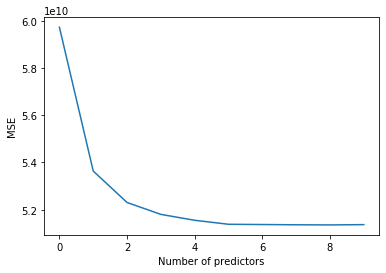

In [25]:
plt.plot(errors)
_ = plt.ylabel("MSE")
_ = plt.xlabel("Number of predictors")

In [26]:
lasso_regression_error = smallest_error
print("Top predictors: " + str(selected_predictors[:smallest_error_index+1]))
print("MSE: " + str(lasso_regression_error))

X = df_train[selected_predictors[:smallest_error_index+1]]
Y = df_train["MARKETVAL"]
lasso = Lasso()
lasso.fit(X, Y)
print(lasso.coef_)
print(lasso.intercept_)

Top predictors: ['BATHROOMS', 'HINCP', 'YRBUILT', 'TOTROOMS', 'HHAGE', 'LOTSIZE', 'BEDROOMS', 'KITCHENS', 'NUMPEOPLE']
MSE: 51355466587.70133
[ 5.76451716e+04  8.47992746e-01 -1.31990023e+03  2.56312940e+04
  1.40522495e+03 -1.33623149e+04 -4.06721929e+03 -1.01983690e+05
 -3.22323915e+03]
2554151.1552422927


## Model 3 - Ridge Regression - Forward Stepwise Selection

In [27]:
predictors = cols[:-1]
selected_predictors = []
errors = []
smallest_error = float("inf")
smallest_error_index = 0

for j in range(len(predictors)):
    
    smallest_mse_index = 0
    smallest_mse = float("inf")
    
    for i, predictor in enumerate(predictors): 
        
        X = df_train[selected_predictors + [predictor]]
        Y = df_train["MARKETVAL"]
        ridge = Ridge()
        ridge.fit(X, Y)
        y_true = df_test["MARKETVAL"]
        y_pred = ridge.predict(df_test[selected_predictors + [predictor]])        
        mse = mean_squared_error(y_true, y_pred)
        
        if mse < smallest_mse:
            smallest_mse = mse
            smallest_mse_index = i
            
            
    selected_predictors.append(predictors.pop(smallest_mse_index))
    errors.append(smallest_mse)
    
    if smallest_mse < smallest_error:
        smallest_error = smallest_mse
        smallest_error_index = j
        

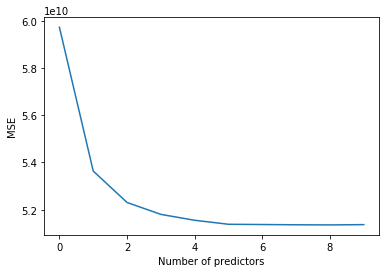

In [28]:
plt.plot(errors)
_ = plt.ylabel("MSE")
_ = plt.xlabel("Number of predictors")

In [29]:
ridge_regression_error = smallest_error
print("Top predictors: " + str(selected_predictors[:smallest_error_index+1]))
print("MSE: " + str(ridge_regression_error))
X = df_train[selected_predictors[:smallest_error_index+1]]
Y = df_train["MARKETVAL"]
ridge = Lasso()
ridge.fit(X, Y)
print(ridge.coef_)
print(ridge.intercept_)

Top predictors: ['BATHROOMS', 'HINCP', 'YRBUILT', 'TOTROOMS', 'HHAGE', 'LOTSIZE', 'BEDROOMS', 'KITCHENS', 'NUMPEOPLE']
MSE: 51355416553.69778
[ 5.76451716e+04  8.47992746e-01 -1.31990023e+03  2.56312940e+04
  1.40522495e+03 -1.33623149e+04 -4.06721929e+03 -1.01983690e+05
 -3.22323915e+03]
2554151.1552422927


In [30]:
print(multiple_linear_regression_error)
print(lasso_regression_error)
print(ridge_regression_error)

51355492438.3039
51355466587.70133
51355416553.69778
